In [8]:
import torch
import numpy as np
import pyquaternion
import os
import math
import matplotlib.pyplot as plt
import diff_gaussian_rasterization_batched as dgrb

In [9]:
device = torch.device("cuda")

# generate a random point cloud
B = 2
N = 10
means3D = torch.cat(
    [
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.rand(B, N, 1, dtype=torch.float32, device=device) * 2 - 1,
        torch.zeros(B, N, 1, dtype=torch.float32, device=device)+1,
    ],
    dim=2,
)
means2D = torch.zeros(B, N, 2, dtype=torch.float32, device=device)
opacities = torch.ones(B, N, 1, dtype=torch.float32, device=device)
scales = torch.ones(B, N, 3, dtype=torch.float32, device=device) * 0.1
rotations = (
    torch.from_numpy(np.stack([pyquaternion.Quaternion().elements for _ in range(N)]))
    .to(torch.float32)
    .to(device)
    .expand(B, N, 4)
)
colors_precomp = torch.rand(B, N, 3, dtype=torch.float32, device=device)

In [10]:
means3D

tensor([[[-0.9598,  0.5390,  1.0000],
         [-0.7016, -0.2904,  1.0000],
         [-0.1914, -0.0661,  1.0000],
         [ 0.3606, -0.0446,  1.0000],
         [-0.0015, -0.4732,  1.0000],
         [-0.7191, -0.0808,  1.0000],
         [-0.7868, -0.6541,  1.0000],
         [-0.2746,  0.8970,  1.0000],
         [-0.9411, -0.6540,  1.0000],
         [-0.7532,  0.2781,  1.0000]],

        [[ 0.0082, -0.6105,  1.0000],
         [ 0.8237,  0.5073,  1.0000],
         [ 0.1879, -0.5125,  1.0000],
         [-0.5070,  0.9801,  1.0000],
         [-0.4348, -0.4425,  1.0000],
         [ 0.1844, -0.3493,  1.0000],
         [-0.3436, -0.8121,  1.0000],
         [-0.4523,  0.6726,  1.0000],
         [ 0.5363, -0.3233,  1.0000],
         [-0.8840, -0.4445,  1.0000]]], device='cuda:0')

In [11]:
# generate the projection matrix (orthographic)

def gen_orthographic_matrix(left: float, right: float, bottom: float, top: float, near: float, far: float):
    """Generate orthographic projection matrix.

    Args:
        left (float): left plane
        right (float): right plane
        bottom (float): bottom plane
        top (float): top plane
        near (float): near plane
        far (float): far plane

    Returns:
        torch.Tensor: orthographic projection matrix
    """
    return torch.tensor([
        [2 / (right - left), 0, 0, -(right + left) / (right - left)],
        [0, 2 / (top - bottom), 0, -(top + bottom) / (top - bottom)],
        [0, 0, -2 / (far - near), -(far + near) / (far - near)],
        [0, 0, 0, 1],
    ])

In [12]:
FoVx = 90
FoVy = 90

raster_settings = dgrb.GaussianRasterizationSettings(
    image_height=512,
    image_width=512,
    tanfovx=math.tan(FoVx * 0.5),
    tanfovy=math.tan(FoVy * 0.5),
    bg=torch.zeros(3, dtype=torch.float32, device=device),
    scale_modifier=1.0,
    viewmatrix=torch.eye(4, dtype=torch.float32, device=device),
    projmatrix=gen_orthographic_matrix(-1, 1, -1, 1, -1, 1).to(device),
    sh_degree=1,
    campos=torch.tensor([0, 0, 0], dtype=torch.float32, device=device),
    prefiltered=False,
    debug=True,
)

rasterizer = dgrb.GaussianRasterizer(raster_settings=raster_settings)

rendered_image, radii = rasterizer(
    means3D=means3D,
    means2D=means2D,
    colors_precomp=colors_precomp,
    opacities=opacities,
    scales=scales,
    rotations=rotations,
)


rendered 1247 points


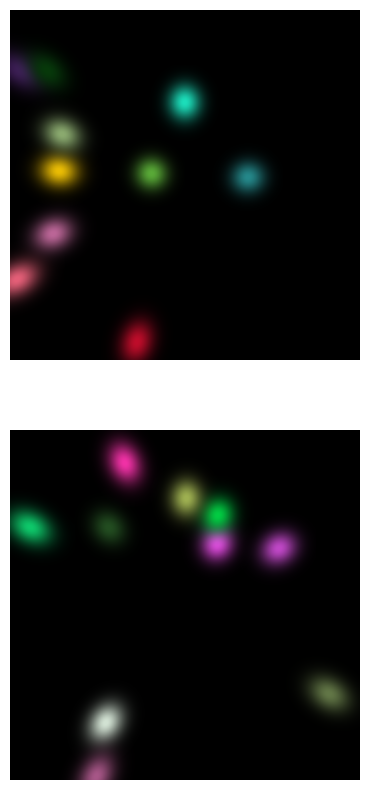

In [16]:
# display the rendered image
image_batch = rendered_image.permute(0, 2, 3, 1).cpu().numpy()
batches = image_batch.shape[0]
fig, ax = plt.subplots(batches, 1, figsize=(10, 10), squeeze=False)
for i in range(batches):
    ax[i, 0].imshow(image_batch[i])
    ax[i, 0].axis("off")

In [14]:
batches

2